In [1]:
import sys
sys.path.append("..")
from architecture import VGG16_BN

import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
# load best model's parameter
model = VGG16_BN()
checkpoint = torch.load('../vgg16_baseline_exp1/checkpoint/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

In [4]:
for param in model.parameters() :
    print(param.shape)

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512,

# what is the convnet filter? (check the architecture)
![](./vgg16_architecture.png)

In [5]:
def numMapsParams(_model) :
    # the number of maps
    num_maps = []
    num_params = []
    for param in _model.parameters() :
        # conv layer weight's the number of maps, the number of params
        if len(param.shape) == 4 : 
            num_maps.append(param.shape[0])
            num_params.append(param.shape[0] * param.shape[1] * param.shape[2] * param.shape[3])
        # fc layer weight's the number of maps
        elif len(param.shape) == 2 :
            num_maps.append(param.shape[0])
            num_params.append(param.shape[0] * param.shape[1])
                
            
    return num_maps, num_params 

# #Maps, #Params, #FLOPs before pruning
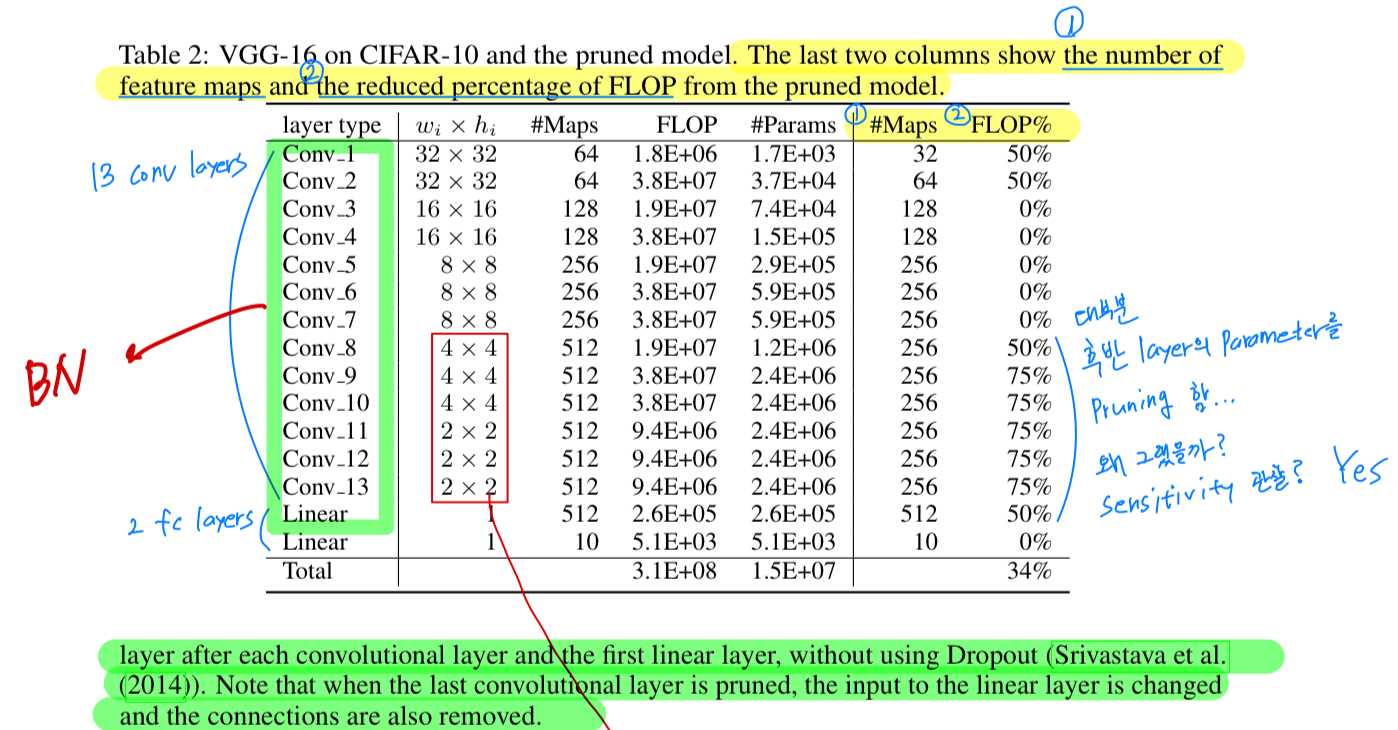

In [6]:
before_num_maps, before_num_params = numMapsParams(model)
before_num_params = [f"{formatted:.1e}" for formatted in before_num_params]

print(f"the number of maps before pruning : {before_num_maps}")
print(f"the number of params before pruning : {before_num_params}")

the number of maps before pruning : [64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512, 512, 10]
the number of params before pruning : ['1.7e+03', '3.7e+04', '7.4e+04', '1.5e+05', '2.9e+05', '5.9e+05', '5.9e+05', '1.2e+06', '2.4e+06', '2.4e+06', '2.4e+06', '2.4e+06', '2.4e+06', '2.6e+05', '5.1e+03']


In [7]:
print("the number of flops before pruning")
! flopth -m VGG16_BN -p ../architecture2 -i 3 32 32

the number of flops before pruning
Op Flatten is not supported at now, set FLOPs of it to zero.
+---------------+---------------+-------------+-------------+------------------------------+----------+------------------+----------------------+----------+-----------------+---------------------+
| module_name   | module_type   | in_shape    | out_shape   | kernel_size,padding,stride   | params   | params_percent   | params_percent_vis   | flops    | flops_percent   | flops_percent_vis   |
+===============+===============+=============+=============+==============================+==========+==================+======================+==========+=================+=====================+
| conv1.0       | Conv2d        | (3,32,32)   | (64,32,32)  | k=(3, 3), p=(1, 1), s=(1, 1) | 1.792K   | 0.0119531%       |                      | 1.83501M | 0.583105%       |                     |
+---------------+---------------+-------------+-------------+------------------------------+----------+-------------

## Figure 2: (a) Sorting filters by absolute weights sum for each layer of VGG-16 on CIFAR-10
* 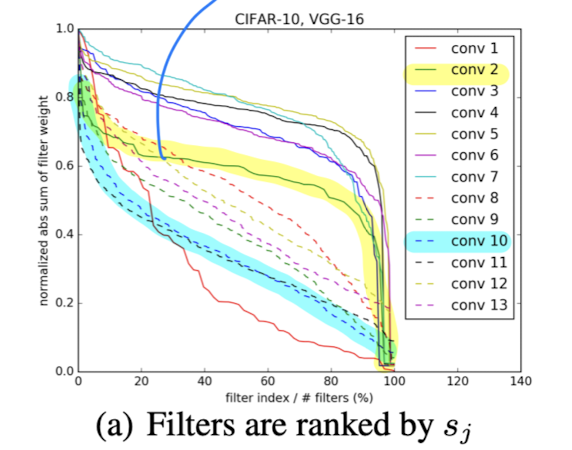

conv1 ----------------------
filter.shape : (64, 3, 3, 3)
sorted_filter.shape : (64,)
conv2 ----------------------
filter.shape : (64, 64, 3, 3)
sorted_filter.shape : (64,)
conv3 ----------------------
filter.shape : (128, 64, 3, 3)
sorted_filter.shape : (128,)
conv4 ----------------------
filter.shape : (128, 128, 3, 3)
sorted_filter.shape : (128,)
conv5 ----------------------
filter.shape : (256, 128, 3, 3)
sorted_filter.shape : (256,)
conv6 ----------------------
filter.shape : (256, 256, 3, 3)
sorted_filter.shape : (256,)
conv7 ----------------------
filter.shape : (256, 256, 3, 3)
sorted_filter.shape : (256,)
conv8 ----------------------
filter.shape : (512, 256, 3, 3)
sorted_filter.shape : (512,)
conv9 ----------------------
filter.shape : (512, 512, 3, 3)
sorted_filter.shape : (512,)
conv10 ----------------------
filter.shape : (512, 512, 3, 3)
sorted_filter.shape : (512,)
conv11 ----------------------
filter.shape : (512, 512, 3, 3)
sorted_filter.shape : (512,)
conv12 ---------

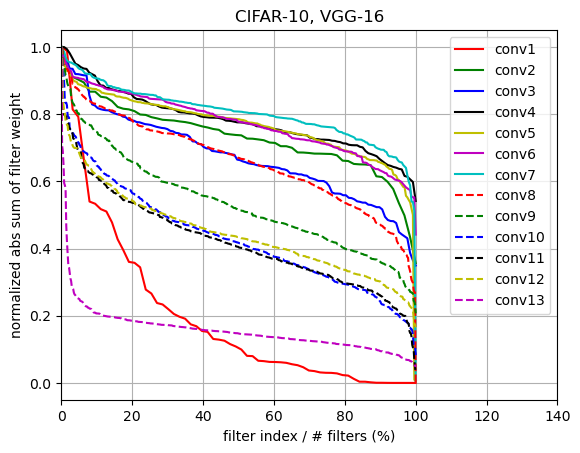

In [8]:
# visualization
## set x data (filter index / # filters (%))
## The y-axis is the filter weight sum divided by the max sum value among filters in that layer.

# plt.figure(figsize=(7, 5))
num_conv_layers = 0

colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
lines = ['-', '--', '-.']
for layer in model.modules() :
    if isinstance(layer, torch.nn.Conv2d) :
        # check filter shape
        print(f"conv{num_conv_layers + 1} ----------------------")
        filter = layer.weight.data.cpu().numpy()
        print(f"filter.shape : {filter.shape}") 
        # L1 norm sorting
        sorted_filter = np.sort(np.sum(np.abs(filter), axis=(1, 2, 3)))[::-1]
        print(f"sorted_filter.shape : {sorted_filter.shape}")
        # filter weight sum divided by the max sum value
        normalized_sorted_filter = sorted_filter / sorted_filter[0]
        # plot
        line_style = colors[num_conv_layers % len(colors)] + lines[num_conv_layers // len(colors)]
        plt.plot(np.linspace(0, 100, normalized_sorted_filter.shape[0]), normalized_sorted_filter, line_style, label=f"conv{num_conv_layers + 1}")
        
        num_conv_layers += 1

    
plt.title("CIFAR-10, VGG-16")
plt.xlabel("filter index / # filters (%)")
plt.ylabel("normalized abs sum of filter weight")
plt.xlim([0, 140])
plt.grid()
plt.legend(loc='upper right')

# save figure
plt.savefig("../Figure2/a.png")

## Figure 2: (b) Prune the smallest filters

* 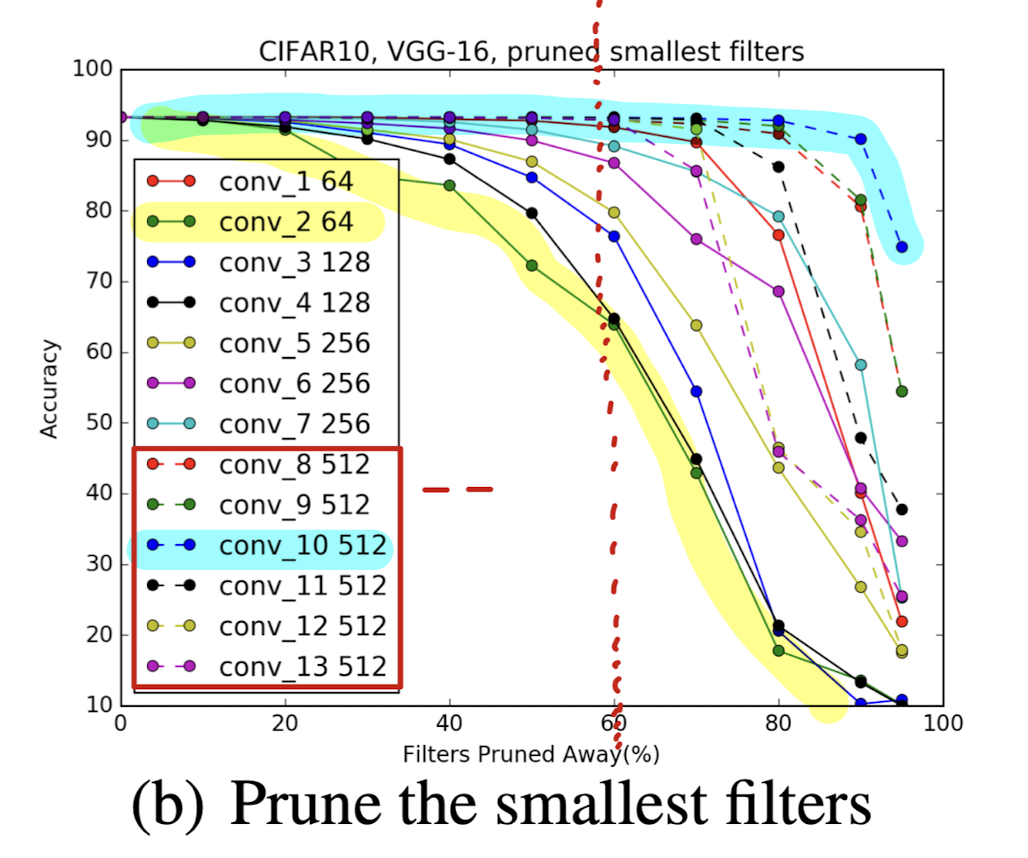

생각, 개발해야 할 것들

1. pytorch에서 pruning을 어떻게 구현해야 하는지?
   * https://pytorch.org/docs/stable/nn.html > import torch.nn.utils.prune as prune
2. pruning을 한다면 다음 layer의 input shape이 연쇄적으로 바뀔텐데, 이를 어떻게 해결할 것인지?
   * Iterative Pruning (`prune.ln_structured()`) 등 여러 함수들이 있던데... 모두 zero로 만들어버릴뿐 연산에 0 matrix가 참여하게 되어 pruning 효과가 없는 듯함
   * 그래서 직접 구현해야 함
3. 13개의 conv layer 각각에 대해서 10가지 경우([10, 20, 30, 40, 50, 60, 70, 80, 90, 95])에 대해서 pruning하여 testing, retraining해야 함.
   -> 총 130가지 경우를 어떻게 training시킬 것인지?

In [131]:
import torch.nn.utils.prune as prune
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import kornia
import matplotlib.pyplot as plt
import numpy as np
from pytorch_model_summary import summary
from torch.nn.parameter import Parameter
import copy
import pickle

In [132]:
def rgb_to_yuv(image) :
    kornia.color.rgb_to_yuv(image)
    return image

def loadValDataset() :
    batch_size = 128
    # load validation dataset
    valset = torchvision.datasets.CIFAR10(
    root='/home/hslee/Desktop/Datasets/', 
    train=False,
    download=True, 
    transform=transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        rgb_to_yuv,
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    )
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                           shuffle=False, num_workers=8, pin_memory=True)
    return val_loader

In [133]:
def testAccuracy(_new_pruned_model, _val_loader) :
    top1_correct = 0
    top1_total = 0
    top1_acc = 0.0
    top5_correct = 0
    top5_total = 0
    top5_acc = 0.0
    
    _new_pruned_model.eval()
    with torch.no_grad():
        for data in _val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = _new_pruned_model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            top1_total += labels.size(0)
            top1_correct += (predicted == labels).sum().item()
            
            top5_total += labels.size(0)
            top5_correct += (torch.topk(outputs.data, 5, dim=1)[1] == labels.view(-1, 1)).sum().sum().item()
            
    top1_acc = 100 * top1_correct / top1_total
    top5_acc = 100 * top5_correct / top5_total
    print(f"Top-1 Accuracy : {top1_acc:.2f} %")
    print(f"Top-5 Accuracy : {top5_acc:.2f} %")
    
    return top1_acc, top5_acc

In [134]:
def getPrunedNetwork(_model, _layer, _num_prune_channels) :
    
    ## 1. parsing _models > _layer > weight, bias, bn_gamma, bn_beta
    current_layer = getattr(_model, f'conv{_layer+1}') 
    conv_layer = current_layer[0]
    bn_layer = current_layer[1]
    weight = conv_layer.weight
    bias = conv_layer.bias
    bn_gamma = bn_layer.weight
    bn_beta = bn_layer.bias
    bn_running_mean = bn_layer.running_mean
    bn_running_var = bn_layer.running_var
    print(f"weight.shape : {weight.shape}")
    print(f"bias.shape : {bias.shape}")
    print(f"bn_gamma.shape : {bn_gamma.shape}")
    print(f"bn_beta.shape : {bn_beta.shape}")
    print(f"bn_running_mean.shape : {bn_running_mean.shape}")
    print(f"bn_running_var.shape : {bn_running_var.shape}")
    is_last_conv_layer = False
    if _layer == 12 :
        is_last_conv_layer = True    
    if is_last_conv_layer :
        next_layer = getattr(_model, f'fc1')
        next_fc_layer = next_layer[1] # nn.Linear(512, 512),
        next_bn_layer = next_layer[2] # nn.BatchNorm1d(512, ...),
    else : 
        next_layer = getattr(_model, f'conv{_layer+2}')
        next_conv_layer = next_layer[0]
        next_bn_layer = next_layer[1]
        next
    
    ## 2. sort the filter with L1 norm (desending order)
    ## bias 값이 매우 작아서 weight pruning index와 동일하게 pruning시킬 것임. (평균적으로 bias가 가장 큰 filter의 값이 약 1e-06 정도임. 최소값은 1e-08)
    sorted_weight, sorted_weight_indices = torch.sort(torch.sum(torch.abs(weight), dim=(1, 2, 3)), descending=True)
    print(f"sorted_weight_indices : {sorted_weight_indices}")
    saving_filter_idices = sorted_weight_indices[0 : -_num_prune_channels]
    print(f"saving_filter_idices : {saving_filter_idices}")
    
    pruned_weight, pruned_bias, \
    pruned_bn_gamma, pruned_bn_beta, \
    pruned_bn_running_mean, pruned_bn_running_var = \
        weight[saving_filter_idices], bias[saving_filter_idices], \
        bn_gamma[saving_filter_idices], bn_beta[saving_filter_idices], \
        bn_running_mean[saving_filter_idices], bn_running_var[saving_filter_idices]  
    print(f"pruned_weight.shape : {pruned_weight.shape}")
    print(f"pruned_bias.shape : {pruned_bias.shape}")
    print(f"pruned_bn_gamma.shape : {pruned_bn_gamma.shape}")
    print(f"pruned_bn_beta.shape : {pruned_bn_beta.shape}")
    print(f"pruned_bn_running_mean.shape : {pruned_bn_running_mean.shape}")
    print(f"pruned_bn_running_var.shape : {pruned_bn_running_var.shape}")
    
    ### next fc layer에 대한 처리 (# ex. conv13 pruned (512, 512, 3, 3) to (496, 512, 3, 3)? fc1 pruned (512, 512) to (512, 496))
    ### (output channel, input channel)
    ### next conv layer에 대한 처리 (# ex. conv1 pruned (64, 3, 3, 3) to (58, 3, 3, 3)? conv2 pruned (64, 64, 3, 3) to (64, 58, 3, 3))
    ### (output channel, input channel, kernel size, kernel size)
    if is_last_conv_layer :
        pruned_next_weight = next_fc_layer.weight[:, saving_filter_idices]
        print(f"pruned_next_weight.shape : {pruned_next_weight.shape}")
    else :
        pruned_next_weight = next_conv_layer.weight[:, saving_filter_idices, :, :]
        print(f"pruned_next_weight.shape : {pruned_next_weight.shape}")
        
    
    # 3. Pruning _model's _layer's weight, bias, bn_gamma, bn_beta with saving_filter_indices 
    with torch.no_grad():
        conv_layer.weight = Parameter(pruned_weight)
        conv_layer.bias = Parameter(pruned_bias)
        bn_layer.weight = Parameter(pruned_bn_gamma)
        bn_layer.bias = Parameter(pruned_bn_beta)
        bn_layer.running_mean.data = Parameter(pruned_bn_running_mean)
        bn_layer.running_var.data = Parameter(pruned_bn_running_var)
        if is_last_conv_layer :
            next_fc_layer.weight = Parameter(pruned_next_weight)
        else :
            next_conv_layer.weight = Parameter(pruned_next_weight)
            
        
    
    return _model

In [135]:
def showNewPrunedModel(_model) :
    print(summary(_model, torch.zeros((1, 3, 32, 32)).to(device), show_input=True))
        

In [136]:
# conv1 ~ conv13까지 돌며 각각 10, 20, 30, 40, 50, 60, 70, 80, 90, 95% pruning 후 accuracy 측정
filters_pruned_away_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95] # (%)
layer = 0
val_loader = loadValDataset()
top1_acc_list = {}
top5_acc_list = {}

# load best model's parameter
model = VGG16_BN()
checkpoint = torch.load('../vgg16_baseline_exp1/checkpoint/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

for param in model.modules() :
    if isinstance(param, torch.nn.Conv2d) :
        top1_acc_list[layer] = []
        top5_acc_list[layer] = []
        print(f"="*40," conv{layer+1} ", "="*40)
        
        for pruned_rate in filters_pruned_away_list :
            model_copy = copy.deepcopy(model)
            num_prune_channels = round(param.weight.data.shape[0] * pruned_rate / 100)
            print(f"\n----- pruned rate : {pruned_rate}%, #pruned channels : {num_prune_channels} -----")
            
            # new_pruned_model architecture
            new_pruned_model = getPrunedNetwork(model_copy, layer, num_prune_channels)
            showNewPrunedModel(new_pruned_model)
            
            # Top-1 accuracy, Top-5 accuracy
            top1_acc, top5_acc = testAccuracy(new_pruned_model, val_loader)
            top1_acc_list[layer].append(top1_acc)
            top5_acc_list[layer].append(top5_acc)
                        

        layer += 1
        
# save accuracy using pickle
with open('../Figure2/b/top1_acc_list.pkl', 'wb') as f :
    pickle.dump(top1_acc_list, f)
with open('../Figure2/b/top5_acc_list.pkl', 'wb') as f :
    pickle.dump(top5_acc_list, f)    


Files already downloaded and verified
========================================  conv{layer+1}  ========================================

----- pruned rate : 10%, #pruned channels : 6 -----
weight.shape : torch.Size([64, 3, 3, 3])
bias.shape : torch.Size([64])
bn_gamma.shape : torch.Size([64])
bn_beta.shape : torch.Size([64])
bn_running_mean.shape : torch.Size([64])
bn_running_var.shape : torch.Size([64])
sorted_weight_indices : tensor([47,  1, 31, 19, 40, 48, 52, 50,  4, 58, 62, 59, 43, 44, 33, 42, 30, 46,
        61, 51, 37, 26, 34, 63, 17, 55,  6, 39,  0, 21, 20, 41, 45, 14, 13, 16,
        29, 10,  8,  5, 54, 49,  2, 32, 11,  9, 57,  3, 24, 15, 60, 36, 23, 56,
        53, 35, 28, 27, 25,  7, 12, 38, 22, 18], device='cuda:0')
saving_filter_idices : tensor([47,  1, 31, 19, 40, 48, 52, 50,  4, 58, 62, 59, 43, 44, 33, 42, 30, 46,
        61, 51, 37, 26, 34, 63, 17, 55,  6, 39,  0, 21, 20, 41, 45, 14, 13, 16,
        29, 10,  8,  5, 54, 49,  2, 32, 11,  9, 57,  3, 24, 15, 60, 36, 23, 56,

KeyboardInterrupt: 

# #Maps, #Params, #FLOPs after pruning